In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [3]:
spark = SparkSession.builder.appName("BMW Worldwide Sales Records (2010–2024)").getOrCreate()

In [15]:
# df = spark.read.csv('')
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/BMW sales data (2010-2024) (1).csv")

print("✅ Data extracted successfully!")


✅ Data extracted successfully!


In [17]:
df.show()

+--------+----+-------------+------+---------+------------+-------------+----------+---------+------------+--------------------+
|   Model|Year|       Region| Color|Fuel_Type|Transmission|Engine_Size_L|Mileage_KM|Price_USD|Sales_Volume|Sales_Classification|
+--------+----+-------------+------+---------+------------+-------------+----------+---------+------------+--------------------+
|5 Series|2016|         Asia|   Red|   Petrol|      Manual|          3.5|    151748|  98740.0|        8300|                High|
|      i8|2013|North America|   Red|   Hybrid|   Automatic|          1.6|    121671|  79219.0|        3428|                 Low|
|5 Series|2022|North America|  Blue|   Petrol|   Automatic|          4.5|     10991| 113265.0|        6994|                 Low|
|      X3|2024|  Middle East|  Blue|   Petrol|   Automatic|          1.7|     27255|  60971.0|        4047|                 Low|
|7 Series|2020|South America| Black|   Diesel|      Manual|          2.1|    122131|  49898.0|   

In [16]:
# E -> Extract
df = (df.withColumn("Year", col("Year").cast("int"))
        .withColumn("Engine_Size_L", col("Engine_Size_L").cast("float"))
        .withColumn("Price_USD", col("Price_USD").cast("float"))
        .withColumn("Sales_Volume", col("Sales_Volume").cast("int")))


In [18]:
df.printSchema()

root
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine_Size_L: float (nullable = true)
 |-- Mileage_KM: integer (nullable = true)
 |-- Price_USD: float (nullable = true)
 |-- Sales_Volume: integer (nullable = true)
 |-- Sales_Classification: string (nullable = true)



In [20]:
df.head()

Row(Model='5 Series', Year=2016, Region='Asia', Color='Red', Fuel_Type='Petrol', Transmission='Manual', Engine_Size_L=3.5, Mileage_KM=151748, Price_USD=98740.0, Sales_Volume=8300, Sales_Classification='High')

In [21]:
output_path = "output/cleaned_data.parquet"
df.write.mode("overwrite").parquet(output_path)
print(f"✅ Data Loaded Successfully into {output_path}")

✅ Data Loaded Successfully into output/cleaned_data.parquet


In [9]:
from pyspark.sql.functions import col, round as spark_round, when

In [22]:
df = spark.read.parquet("output/cleaned_data.parquet")
df.createOrReplaceTempView("bmw")

In [25]:
print("📈 Top 5 Models by Sales Volume:")

spark.sql("""
  select Model,sum(Sales_Volume) as Total_Sales
  from bmw
  group by model
  order by total_sales desc
""").show()

📈 Top 5 Models by Sales Volume:
+--------+-----------+
|   Model|Total_Sales|
+--------+-----------+
|7 Series|   23786466|
|      i8|   23423891|
|      X1|   23406060|
|3 Series|   23281303|
|      i3|   23133849|
|5 Series|   23097519|
|      M5|   22779688|
|      X3|   22745529|
|      X5|   22709749|
|      X6|   22661986|
|      M3|   22349694|
+--------+-----------+



In [27]:
print("📊 Average Price by Fuel Type:")
spark.sql("""
    select Fuel_Type, round(avg(Price_USD), 2) as Avg_Price
    from bmw
    group by Fuel_Type
""").show()

📊 Average Price by Fuel Type:
+---------+---------+
|Fuel_Type|Avg_Price|
+---------+---------+
|   Diesel| 75079.81|
|   Hybrid| 74797.55|
| Electric| 75276.31|
|   Petrol| 74990.42|
+---------+---------+



In [28]:
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
sales_by_year = df.groupBy("Year").sum("Sales_Volume").orderBy("Year")
pdf = sales_by_year.toPandas()

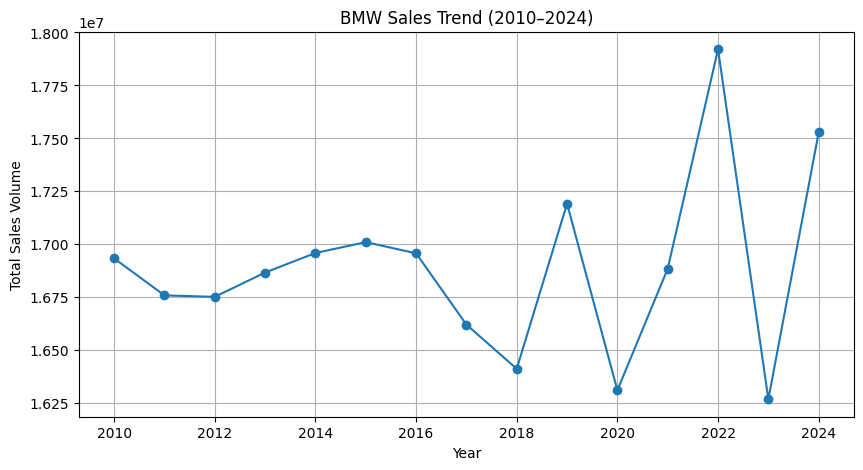

In [30]:
plt.figure(figsize=(10,5))
plt.plot(pdf["Year"],pdf["sum(Sales_Volume)"], marker='o')
plt.title("BMW Sales Trend (2010–2024)")
plt.xlabel("Year")
plt.ylabel("Total Sales Volume")
plt.grid(True)
plt.show()